<a href="https://colab.research.google.com/github/sdhilip200/Content-Based-Recommendation---Good-Reads-data/blob/master/Recommendation_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kguttas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reading the data
df = pd.read_csv("data/data.csv")


In [3]:
df.head()

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [4]:
df["genre"].unique()

array(['Business', 'Non-Fiction'], dtype=object)

In [5]:
df.columns

Index(['Unnamed: 0', 'Desc', 'Unnamed: 0.1', 'author', 'genre', 'image_link',
       'rating', 'title'],
      dtype='object')

In [6]:
len(df)

2382

In [7]:
df2 = pd.DataFrame([{'Unnamed': 9999, 
       'Desc': 'We want find a programmer or developer for project in Java or .NET framework, with 3 years of experience', 
       'Unnamed': 0.4, 
       'author': "Mauricio Estrada",  
       'genre': "Job", 
       'image_link': "https://image.tmdb.org/t/p/original/wwemzKWzjKYJFfCeiB57q3r4Bcm.png",
       'rating': 5.0, 
       'title': "Java Developer"}])

df = df.append(df2, ignore_index = True)

# Text Preprocessing

In [8]:
#Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [9]:
df['Desc'] = df['Desc'].astype(str)
df['cleaned'] = df['Desc'].apply(_removeNonAscii)

df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)


# Building Average Word2Vec Model

In [10]:
# Downloading the Google pretrained Word2Vec Model
#!wget -P data/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [11]:
EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin.gz'
#google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


In [12]:
#splitting the description into words

i = 0
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [13]:
df['cleaned']

0       know power shifting west east north south pres...
1       following success accidental billionaires mone...
2       tap power social software networks build busin...
3       william j bernstein american financial theoris...
4       amazing book joined steve jobs many akio morit...
                              ...                        
2378    murder vicarage marks debut agatha christies u...
2379    1951 john wyndham published novel day triffids...
2380    classic book revealed flannery o connor one or...
2381    imbued every page frank mccourt s astounding h...
2382    want find programmer developer project java ne...
Name: cleaned, Length: 2383, dtype: object

In [14]:
# Training our corpus with Google Pretrained Model
%time
google_model = Word2Vec(vector_size  = 300, window=5, min_count = 1, workers = -1)

google_model.build_vocab(corpus)

google_model.wv.vectors_lockf = np.ones(len(google_model.wv), dtype= np.float64)

#model=Word2Vec.load("data/GoogleNews-vectors-negative300.bin")

google_model.wv.intersect_word2vec_format("data/GoogleNews-vectors-negative300.bin", lockf=1.0, binary=True)

#google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


(0, 0)

In [15]:
google_model.wv.most_similar(positive=["car"])

[('vehicle', 0.7821096181869507),
 ('cars', 0.7423830032348633),
 ('truck', 0.6735789775848389),
 ('motorcycle', 0.6256055235862732),
 ('van', 0.6115673184394836),
 ('vehicles', 0.5998871326446533),
 ('motorbike', 0.5921168327331543),
 ('bike', 0.5854154229164124),
 ('automobile', 0.5838367342948914),
 ('driver', 0.5779394507408142)]

In [16]:
google_model.wv.most_similar(positive=["project"])

[('projects', 0.7522066831588745),
 ('construction', 0.594023585319519),
 ('development', 0.5120325684547424),
 ('renovation', 0.5105037689208984),
 ('initiative', 0.4811692535877228),
 ('construct', 0.46428564190864563),
 ('venture', 0.4381137192249298),
 ('conceptual', 0.43257424235343933),
 ('program', 0.4301757216453552),
 ('endeavor', 0.42472636699676514)]

In [17]:
# Generate the average word2vec for the each book description

def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv[word]
                else:
                    avgword2vec = avgword2vec + google_model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)


In [18]:
# Recommending the Top 5 similar books

def recommendations(title):
    
    # Calling the function vectors

    vectors(df)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    print(len(word_embeddings))
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

2383


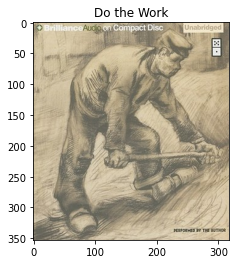

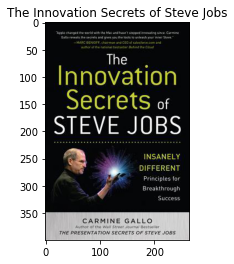

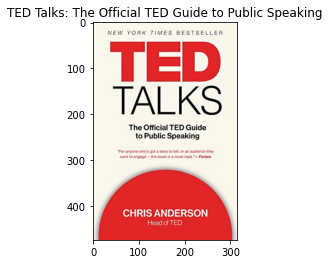

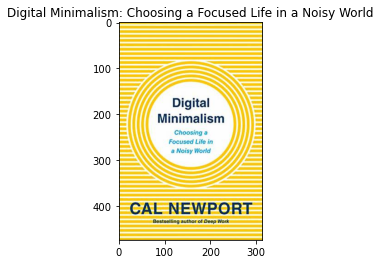

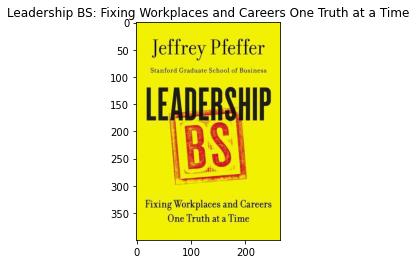

In [19]:
recommendations("Java Developer")

2383


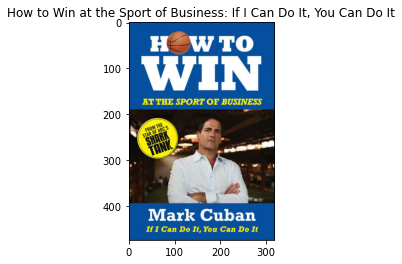

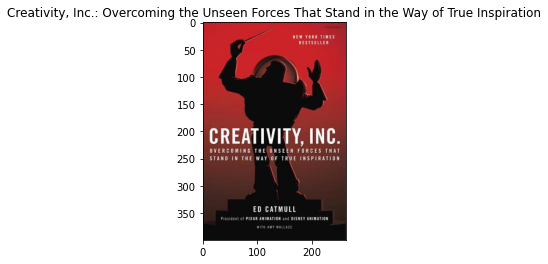

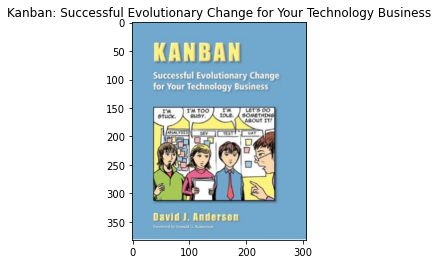

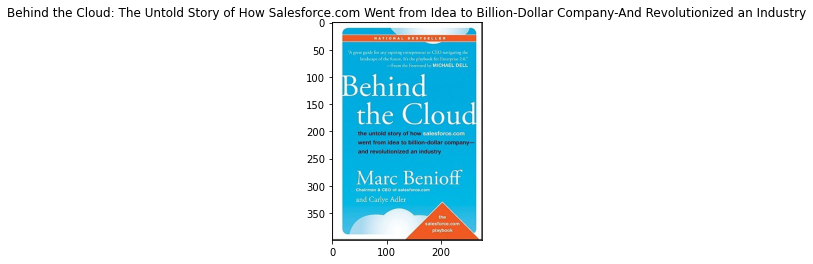

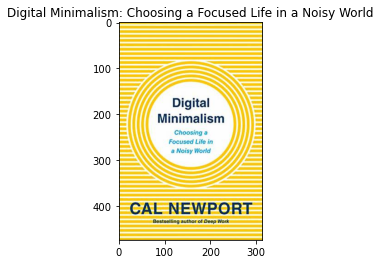

In [20]:
recommendations("Steve Jobs")

In [21]:
df_new = pd.DataFrame([{'Unnamed': 9999, 
       'Desc': 'We want find a programmer or developer for project in Golang or Rust, with 2 years of experience', 
       'Unnamed': 0.4, 
       'author': "Mauricio Estrada",  
       'genre': "Job", 
       'image_link': "https://image.tmdb.org/t/p/original/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg",
       'rating': 5.0, 
       'title': "Golang Developer"}])

df_new['Desc'] = df_new['Desc'].astype(str)
df_new['cleaned'] = df_new['Desc'].apply(_removeNonAscii)

df_new['cleaned'] = df_new.cleaned.apply(func = make_lower_case)
df_new['cleaned'] = df_new.cleaned.apply(func = remove_stop_words)
df_new['cleaned'] = df_new.cleaned.apply(func=remove_punctuation)
df_new['cleaned'] = df_new.cleaned.apply(func=remove_html)

df = df.append(df_new, ignore_index = True)


i = 0
corpus_new = []
for words in df_new['cleaned']:
    corpus_new.append(words.split())
    corpus.append(words)
    

In [22]:
google_model.build_vocab(corpus_new, update=True)

#google_model.wv.vectors_lockf = np.ones(len(google_model.wv), dtype= np.float64)

#model=Word2Vec.load("data/GoogleNews-vectors-negative300.bin")

#google_model.wv.intersect_word2vec_format("data/GoogleNews-vectors-negative300.bin", lockf=1.0, binary=True)

#google_model.wv.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

#google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)


2384


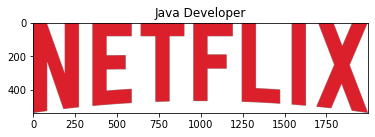

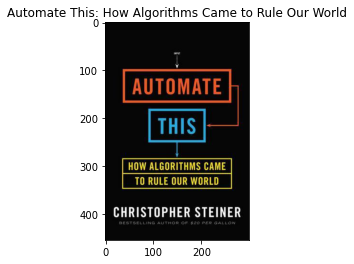

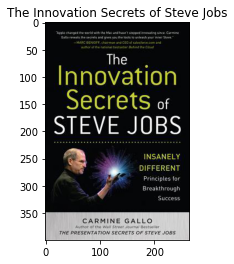

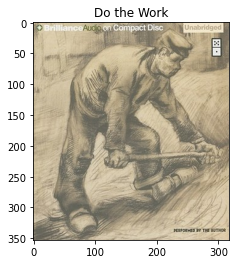

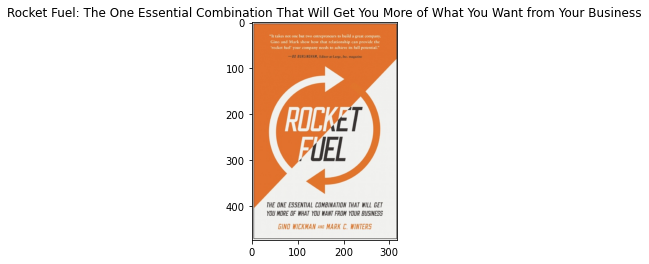

In [23]:
recommendations("Golang Developer")

# Building TF-IDF Word2Vec Model

In [41]:
#Building TFIDF model and calculate TFIDF score

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 0.0009, stop_words='english')
tfidf.fit(df['cleaned'])

# Getting the words from the TF-IDF model

tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

In [42]:
len(corpus)

2384

In [43]:
# Building TF-IDF Word2Vec 

# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = []; 
line = 0;
# for each book description
for desc in corpus: 
  # Word vectors are of zero length (Used 300 dimensions)
    sent_vec = np.zeros(300) 
    # num of words with a valid vector in the book description
    weight_sum =0; 
    # for each word in the book description
    for word in desc: 
        #print(word)
        if word in google_model.wv.key_to_index and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

In [44]:
#Recommending top 5 similar books

def recommendations(title):
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)
    
    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
    print(cosine_similarities[5])
    idx = indices[title]
    print(idx)
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

[0.59656433 0.79241503 0.52367371 ... 0.48257189 0.437406   0.        ]
2383


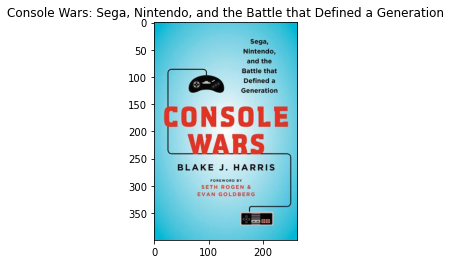

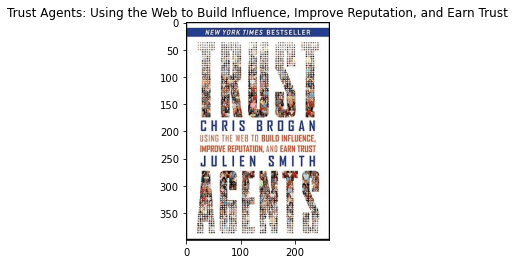

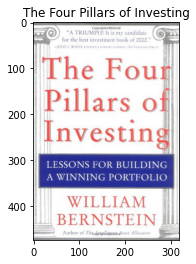

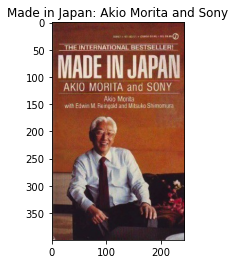

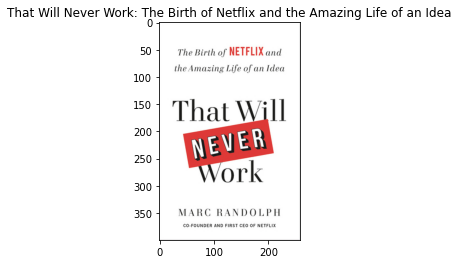

In [45]:
recommendations("Golang Developer")

[0.59656433 0.79241503 0.52367371 ... 0.48257189 0.437406   0.        ]
3


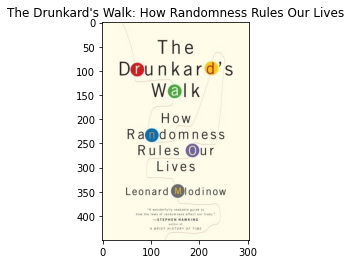

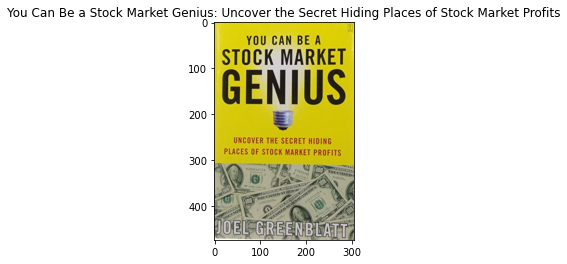

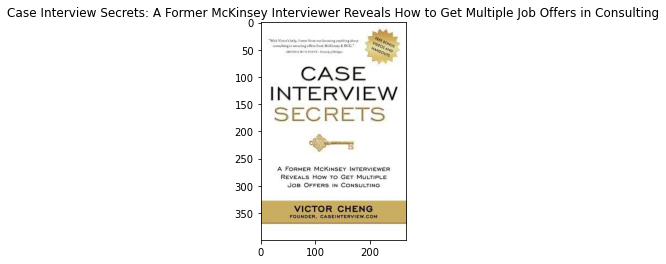

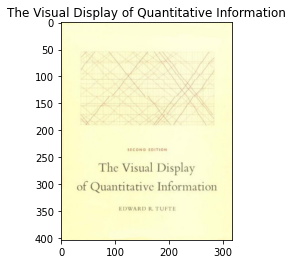

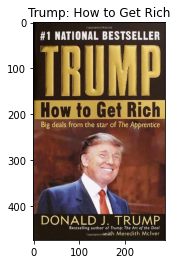

In [46]:
recommendations("The Four Pillars of Investing")

[0.59656433 0.79241503 0.52367371 ... 0.48257189 0.437406   0.        ]
2382


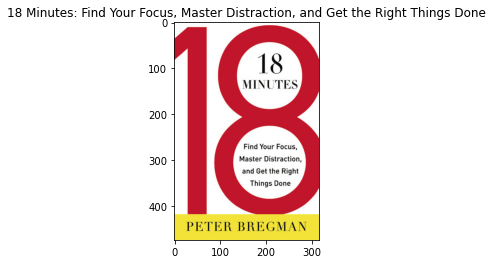

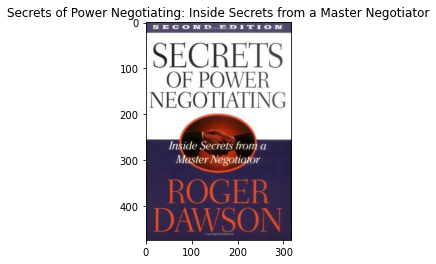

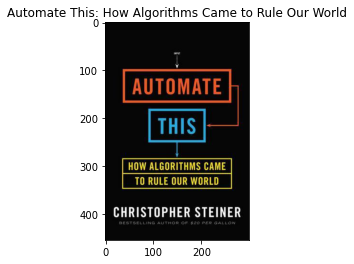

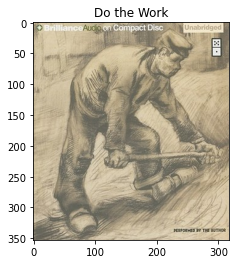

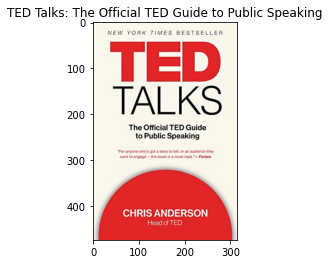

In [48]:
recommendations("Java Developer")

[0.59656433 0.79241503 0.52367371 ... 0.48257189 0.437406   0.        ]
2383


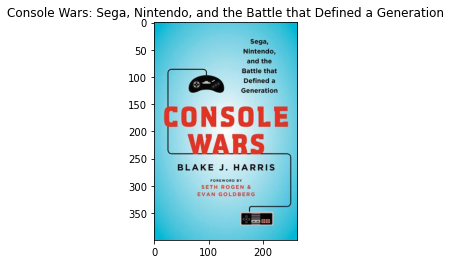

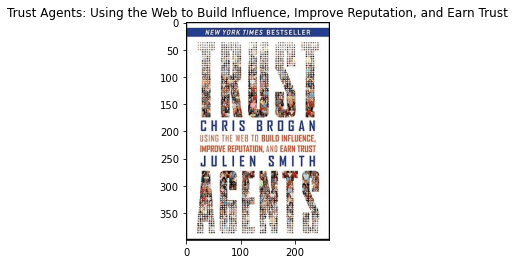

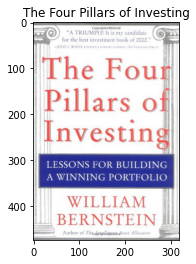

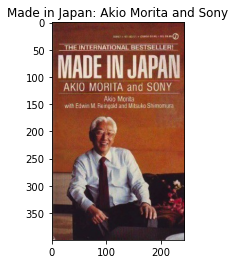

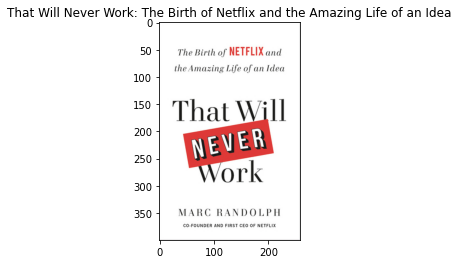

In [47]:
recommendations("Golang Developer")